In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os
import admix
from os.path import join
import itertools
import admix_genet_cor
import submitit
import glob
from scipy.stats import pearsonr, linregress
from tqdm import tqdm
import string

In [2]:
# define the simulation parameters
df_real_params = pd.DataFrame(
    [
        params
        for params in itertools.product(
            ["real"],
            [f"region{i}" for i in np.arange(100)],
            [0.002, 0.006, 0.01],
            [1],
        )
    ],
    columns=["group", "region", "hsq", "ncausal"],
)
df_simu_params = pd.DataFrame(
    [
        params
        for params in itertools.product(
            ["simu"],
            [f"region{i}.eur20.afr80" for i in np.arange(50)],
            #             [f"region{i}.eur80.afr20" for i in np.arange(50)],
            [0.002, 0.006, 0.01],
            [1, 41],
        )
    ],
    columns=["group", "region", "hsq", "ncausal"],
)
# df_params = pd.concat([df_real_params, df_simu_params])
df_params = df_real_params
df_params["config"] = df_params.apply(
    lambda row: f"group-{row.group}-region-{row.region}-hsq-{row.hsq}-ncausal-{int(row.ncausal)}",
    axis=1,
)

In [3]:
dict_df_res = {}

for group in ["causal", "clump"]:
    df_res = []
    for param_i, param in tqdm(df_params.iterrows(), total=len(df_params)):
        for sim_i in range(100):
            path = f"out/covar-pc/summary/{param.config}/sim_{sim_i}.{group}.tsv"
            if os.path.exists(path):
                df_tmp = pd.read_csv(path, sep="\t")
                df_tmp["group"] = param.group
                df_tmp["region"] = param.region
                df_tmp["ncausal"] = param.ncausal
                df_tmp["hsq"] = param.hsq
                df_tmp["sim_i"] = sim_i
                df_res.append(df_tmp)

    df_res = pd.concat(df_res).reset_index(drop=True)
    # filter for SNPs with super small MAF in either one of the populations
    df_res = df_res[(df_res.se1 > 1e-6) & (df_res.se2 > 1e-6)]
    print(group, np.mean(df_res.het_pval < 0.05))
    dict_df_res[group] = df_res

100%|██████████| 300/300 [08:54<00:00,  1.78s/it]


causal 0.04907221104404203


100%|██████████| 300/300 [10:46<00:00,  2.16s/it]


clump 0.09882761129298526


In [5]:
def summarize_res(df_res_grouped):
    # 1st local ancestry = AFR, 2nd local ancestry = EUR
    df_plot = pd.DataFrame(
        {
            "het_inflation": df_res_grouped.apply(
                lambda x: admix.data.lambda_gc(x["het_pval"])
            ),  # HET p-value
            "het_fpr": df_res_grouped.apply(lambda x: np.mean(x["het_pval"] < 0.05)),
            "pearsonr": df_res_grouped.apply(
                lambda x: pearsonr(x["coef1"], x["coef2"])[0]
            ),  # Pearson's correlation between two coefficents
            "deming_afr~eur": df_res_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef1"], y=x["coef2"], sx=x["se1"], sy=x["se2"]
                )[0]
            ),  # EUR ~ AFR
            "deming_eur~afr": df_res_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef2"], y=x["coef1"], sx=x["se2"], sy=x["se1"]
                )[0]
            ),  # AFR ~ EUR
            "ols_afr~eur": df_res_grouped.apply(
                lambda x: linregress(x=x["coef1"], y=x["coef2"])[0]
            ),
            "ols_eur~afr": df_res_grouped.apply(
                lambda x: linregress(x=x["coef2"], y=x["coef1"])[0]
            ),
        }
    )

    df_plot = df_plot.reset_index(drop=False)
    return df_plot

In [6]:
df_plot = summarize_res(dict_df_res["clump"].groupby(["ncausal", "hsq", "sim_i"]))

In [7]:
# df_tmp = dict_df_res["clump"].copy()
# df_tmp = df_tmp[(df_tmp.ncausal == 41) & (df_tmp.hsq == 0.006) & (df_tmp.sim_i == 3)]
# # df_tmp = df_tmp[(df_tmp.se1.between(0.01, 0.1)) & (df_tmp.se2.between(0.01, 0.1))]
# fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
# ax.scatter(df_tmp.coef1, df_tmp.coef2, s=1, alpha=0.5)
# lim = max(np.abs(df_tmp.coef1).max(), np.abs(df_tmp.coef2).max()) / 2
# ax.set_xlim(-lim, lim)
# ax.set_ylim(-lim, lim)
# slope = admix_genet_cor.locus.deming_regression(
#     x=df_tmp.coef1, y=df_tmp.coef2, sx=df_tmp.se1, sy=df_tmp.se2, no_intercept=True
# )
# print(slope)
# ax.plot([-lim, lim], [-lim * slope, lim * slope], "r--", alpha=0.5)
# ax.axhline(y=0, color="gray", ls="--", alpha=0.5)
# ax.axvline(x=0, color="gray", ls="--", alpha=0.5)

# ax.set_xlabel("European (20%)")
# ax.set_ylabel("African (80%)")

In [8]:
dict_df_plot = {}

for group in ["causal", "clump"]:
    df_plot = summarize_res(
        dict_df_res[group].groupby(["ncausal", "hsq", "sim_i"])
    ).drop(columns=["sim_i"])
    df_plot_mean = df_plot.groupby(["ncausal", "hsq"]).mean().reset_index()
    df_plot_sem = df_plot.groupby(["ncausal", "hsq"]).sem().reset_index()

    dict_df_plot[group] = (df_plot_mean, df_plot_sem)

In [9]:
for group in ["causal", "clump"]:
    print(group + ":")
    df_plot_mean, df_plot_sem = dict_df_plot[group]
    display(
        df_plot_mean.set_index(["ncausal", "hsq"]).round(3).astype(str)
        + "±"
        + df_plot_sem.set_index(["ncausal", "hsq"]).round(3).astype(str)
    )

causal:


het_inflation      het_fpr     pearsonr deming_afr~eur  \
ncausal hsq                                                            
1       0.002   0.973±0.027   0.05±0.003  0.917±0.002    1.002±0.004   
        0.006    1.03±0.023   0.05±0.002  0.964±0.001    0.997±0.002   
        0.010   1.027±0.025  0.047±0.002    0.979±0.0    0.999±0.002   

              deming_eur~afr  ols_afr~eur  ols_eur~afr  
ncausal hsq                                             
1       0.002      1.0±0.004  0.886±0.006  0.954±0.007  
        0.006    1.004±0.002  0.946±0.003  0.984±0.004  
        0.010    1.001±0.002  0.968±0.003   0.99±0.003

clump:


het_inflation      het_fpr     pearsonr deming_afr~eur  \
ncausal hsq                                                            
1       0.002   0.959±0.029  0.048±0.002   0.884±0.01    1.003±0.004   
        0.006   1.068±0.022  0.065±0.002  0.874±0.009    0.995±0.002   
        0.010   1.415±0.026  0.139±0.003  0.716±0.009    0.984±0.002   

              deming_eur~afr  ols_afr~eur  ols_eur~afr  
ncausal hsq                                             
1       0.002    0.998±0.004  0.849±0.014   0.93±0.011  
        0.006    1.005±0.002  0.816±0.014  0.946±0.009  
        0.010    1.017±0.002  0.578±0.012  0.898±0.011

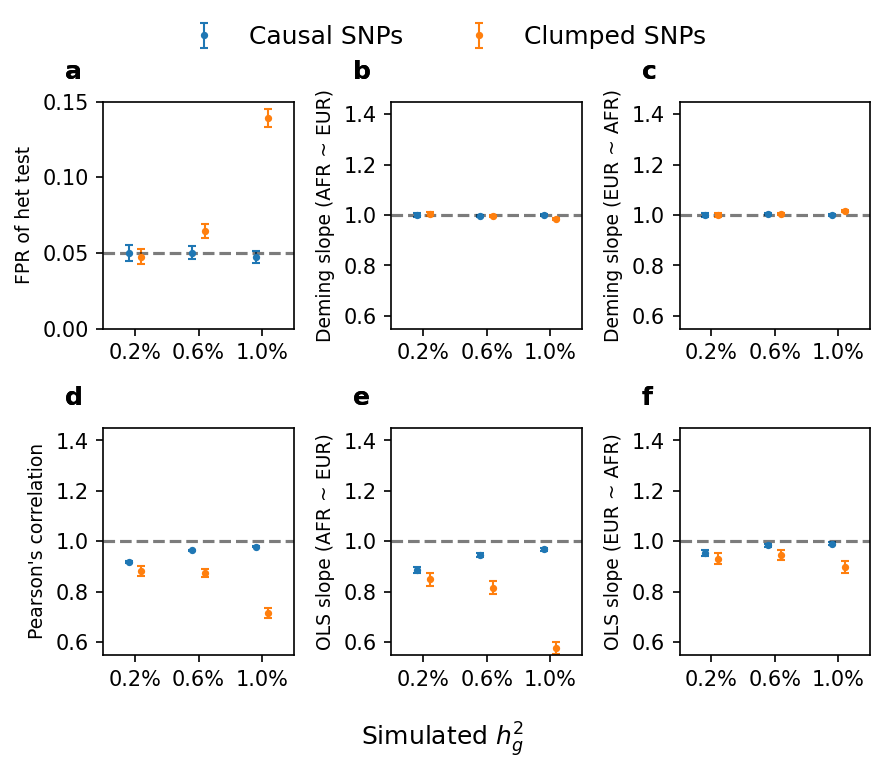

In [10]:
y_var_list = [
    "het_fpr",
    "deming_afr~eur",
    "deming_eur~afr",
    "pearsonr",
    "ols_afr~eur",
    "ols_eur~afr",
]
y_label_list = [
    "FPR of het test",
    "Deming slope (AFR ~ EUR)",
    "Deming slope (EUR ~ AFR)",
    "Pearson's correlation",
    "OLS slope (AFR ~ EUR)",
    "OLS slope (EUR ~ AFR)",
]
dict_ylim = {
    "het_fpr": [0, 0.15],
    "pearsonr": [0.55, 1.45],
    "ols_afr~eur": [0.55, 1.45],
    "ols_eur~afr": [0.55, 1.45],
    "deming_afr~eur": [0.55, 1.45],
    "deming_eur~afr": [0.55, 1.45],
}
dict_hline = {
    "het_fpr": 0.05,
    "pearsonr": 1.0,
    "ols_afr~eur": 1.0,
    "ols_eur~afr": 1.0,
    "deming_afr~eur": 1.0,
    "deming_eur~afr": 1.0,
}

fig, axes = plt.subplots(figsize=(6, 4.5), ncols=len(y_var_list) // 2, nrows=2, dpi=150)
axes = axes.flatten()

# for causal SNPs and clumped SNPs
for group_i, group in enumerate(["causal", "clump"]):
    df_mean, df_sem = dict_df_plot[group]
    # filter for single causal variant
    df_mean = df_mean[df_mean.ncausal == 1].drop(columns=["ncausal"])
    df_sem = df_sem[df_sem.ncausal == 1].drop(columns=["ncausal"])

    # for each panel
    for i, (y_var, y_label) in enumerate(zip(y_var_list, y_label_list)):
        ax = axes[i]
        hsq_list = df_mean.hsq.unique()

        if i == 0:
            label = "Causal SNPs" if group == "causal" else "Clumped SNPs"
        else:
            label = None

        ax.errorbar(
            np.arange(len(hsq_list)) - 0.1 + 0.2 * group_i,
            df_mean[y_var],
            yerr=df_sem[y_var] * 1.96,
            fmt=".",
            ms=5,
            mew=1,
            label=label,
            linewidth=1,
            capsize=2,
        )

        ax.axhline(y=dict_hline[y_var], color="black", ls="--", alpha=0.3)
        ax.set_xticks(np.arange(len(hsq_list)))
        ax.set_xticklabels([f"{hsq * 100}%" for hsq in hsq_list])
        ax.set_xlim(-0.5, len(hsq_list) - 0.5)

        ax.set_ylabel(y_label, fontsize=9)

        ax.set_ylim(dict_ylim[y_var])

        # annotation
        ax.text(
            -0.2,
            1.1,
            string.ascii_lowercase[i],
            transform=ax.transAxes,
            size=12,
            weight="bold",
        )

# trick to put title in the same row
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    ncol=5,
    loc="center",
    bbox_to_anchor=[0.5, 1.0],
    frameon=False,
    fontsize=12,
)

fig.text(
    0.5,
    -0.05,
    "Simulated $h_g^2$",
    fontsize=12,
    ha="center",
)

plt.tight_layout()

plt.show()

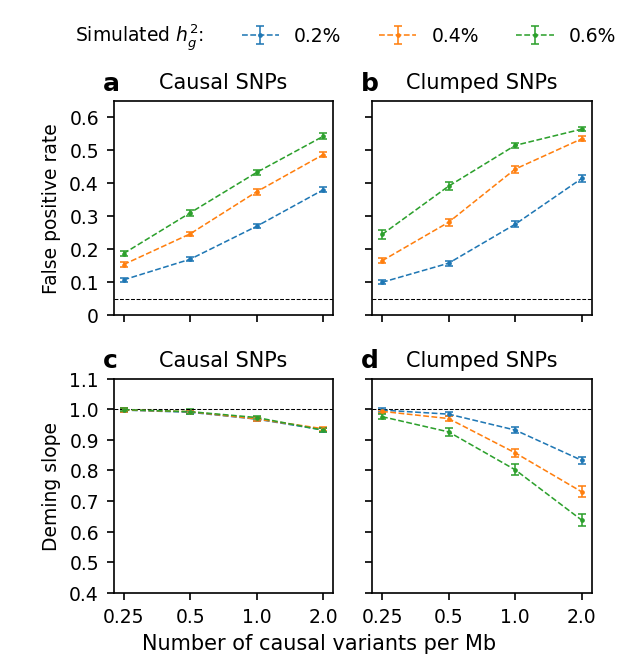

In [29]:
yvar_list = [
    "het_fpr",
    "deming_afr~eur",
]
dict_ylabel = {
    "het_fpr": "False positive rate",
    "deming_afr~eur": "Deming slope",
}
dict_ylim = {
    "het_fpr": [0, 0.65],
    "deming_afr~eur": [0.4, 1.1],
}
dict_yticks = {
    "het_fpr": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    "deming_afr~eur": [np.round(f, 1) for f in np.linspace(0.4, 1.1, 8)],
}
fig, axes = plt.subplots(
    figsize=(4, 4), nrows=2, ncols=2, dpi=150, sharex=True, sharey="row"
)
for group_i, group in enumerate(["causal", "clump"]):
    df_mean, df_sem = dict_df_plot[group]
    # filter for multiple causal
    df_mean = df_mean[df_mean.ncausal > 3]
    df_sem = df_sem[df_sem.ncausal > 3]

    for yvar_i, yvar in enumerate(yvar_list):
        ax = axes[yvar_i, group_i]
        for hsq_i, hsq in enumerate(df_plot.hsq.unique()):
            df_mean_tmp = df_mean[df_mean.hsq == hsq]
            df_sem_tmp = df_sem[df_sem.hsq == hsq]
            ax.errorbar(
                np.arange(len(df_mean_tmp.ncausal)),
                df_mean_tmp[yvar],
                yerr=df_sem_tmp[yvar] * 1.96,
                fmt=".--",
                label=f"{hsq * 100}%",
                ms=3,
                linewidth=0.75,
                mew=0.75,
                capsize=2,
            )

        ax.axhline(y=dict_hline[yvar], color="black", ls="--", alpha=1.0, lw=0.5)
        ax.set_xticks(np.arange(len(df_mean_tmp.ncausal)))

        #         ax.set_xticklabels(df_mean_tmp.ncausal, fontsize=9)
        ax.set_xticklabels([str(i) for i in (df_mean_tmp.ncausal - 1) / 20], fontsize=9)
        ax.set_yticks(dict_yticks[yvar])
        ax.set_yticklabels(dict_yticks[yvar], fontsize=9)
        if group_i == 0:
            ax.set_ylabel(dict_ylabel[yvar], fontsize=9)
            ax.set_ylim(dict_ylim[yvar])

        if group == "causal":
            ax.set_title("Causal SNPs", fontsize=10)
        elif group == "clump":
            ax.set_title("Clumped SNPs", fontsize=10)

        # annotation
        ax.text(
            -0.05,
            1.05,
            string.ascii_lowercase[yvar_i * 2 + group_i],
            transform=ax.transAxes,
            size=12,
            weight="bold",
        )

# trick to put title in the same row
handles, labels = axes[0, 0].get_legend_handles_labels()
ph = [plt.plot([], marker="", ls="")[0]]  # Canvas
handles = ph + handles
labels = ["Simulated $h_g^2$:"] + labels  # Merging labels
fig.legend(
    handles,
    labels,
    ncol=6,
    loc="center",
    bbox_to_anchor=[0.5, 1.02],
    frameon=False,
    fontsize=9,
)

fig.text(
    0.5,
    -0.0,
    "Number of causal variants per Mb",
    fontsize=10,
    ha="center",
)


plt.tight_layout()
plt.show()